In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.8.0+cpu'

### 1. Data (preparing and loading)
I want to stress that "data" in machine learning can be almost anything you can imagine. A table of numbers (like a big Excel spreadsheet), images of any kind, videos (YouTube has lots of data!), audio files like songs or podcasts, protein structures, text and more.

In [3]:
# create a samlpe dataset
weight = 0.7
bais = 0.3

X = torch.arange(start=0 , end=1 , step=0.02)
y = weight * X + bais 

# see X and y
print(X.shape)
# get the first 10 elements
X[ : 10] , y[:10]

torch.Size([50])


(tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
         0.1800]),
 tensor([0.3000, 0.3140, 0.3280, 0.3420, 0.3560, 0.3700, 0.3840, 0.3980, 0.4120,
         0.4260]))

Now we're going to move towards building a model that can learn the relationship between X (features) and y (labels).

### Split data into training and test sets

In [4]:
splitter = int(len(X)*0.8) 

# spliting data 80 -> train and 20 -> test
X_train , y_train = X[:splitter] , y[:splitter]
X_test , y_test = X[splitter : ] , y[splitter :]

len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

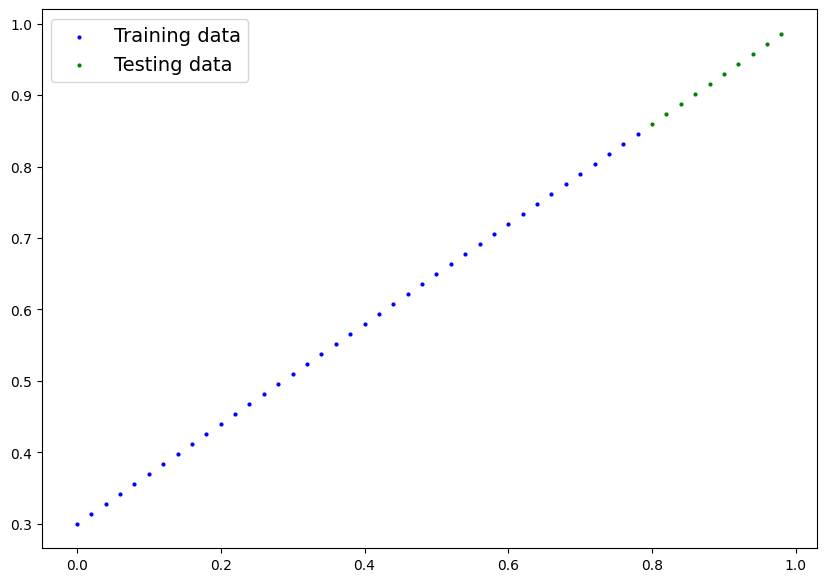

In [6]:
plot_predictions()

### Creating a neural network - Linear Regression model 

In [7]:
import torch
import torch.nn as nn

class LinearRegressionModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Starting with random initial weights (slope 'm')
        self.weights = nn.Parameter(
            torch.randn(1, dtype=torch.float),  # tensor with shape (1,)
            requires_grad=True
        )

        # Starting with random initial bias (intercept 'c')
        self.bias = nn.Parameter(
            torch.randn(1, dtype=torch.float),  # tensor with shape (1,)
            requires_grad=True
        )

    # Forward pass: y = m*x + c
    def forward(self, x: torch.Tensor):
        return self.weights * x + self.bias


![Alt text](./images/1.png)

![Alt text](./images/2.png)


Checking the contents of a PyTorch model

In [8]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

torch.inference_mode() turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the forward() method) faster.

- Note: In older PyTorch code, you may also see torch.no_grad() being used for inference. While torch.inference_mode() and torch.no_grad() do similar things, torch.inference_mode() is newer, potentially faster and preferred. See this Tweet from PyTorch for more.

In [10]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)
    print(y_preds)

tensor([0.3982, 0.4049, 0.4116, 0.4184, 0.4251, 0.4318, 0.4386, 0.4453, 0.4520,
        0.4588])


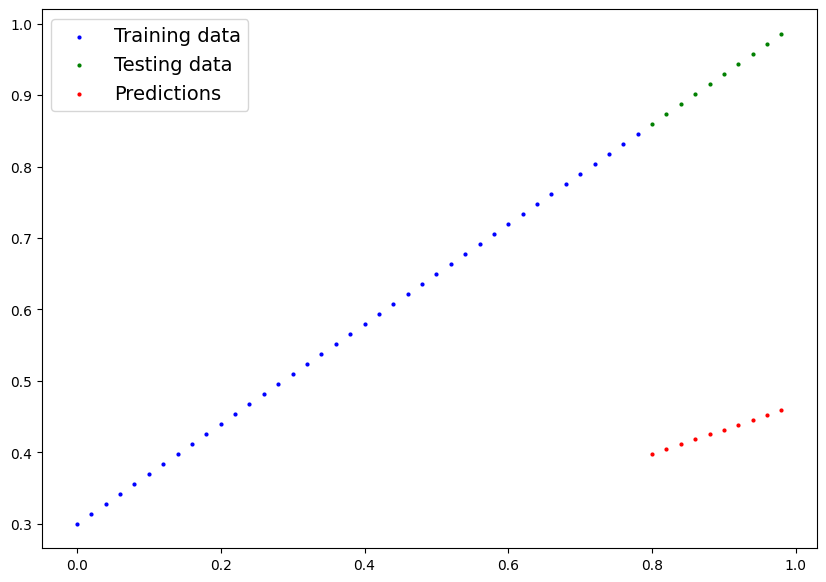

In [11]:
plot_predictions(predictions=y_preds)

In [12]:
y_test - y_preds

tensor([0.4618, 0.4691, 0.4764, 0.4836, 0.4909, 0.4982, 0.5054, 0.5127, 0.5200,
        0.5272])

This makes sense though, when you remember our model is just using random parameter values to make predictions.

It hasn't even looked at the blue dots to try to predict the green dots.

### Train the model


Creating a loss function and optimizer in PyTorch
For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a loss function as well as an optimizer.

![image.png](./images/3.png)



### Creating loss functions and optimizers

In [15]:
# loss function -> mean absolute error (MAE)
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD( params= model_0.parameters() # parameters of target model to optimize
                             , lr= 0.001  #  learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))
                            )

### PyTorch training loop

![image.png](./images/4.png)
![image.png](./images/5.png)



In [17]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 1000

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.19767141342163086 | MAE Test Loss: 0.35847947001457214 
Epoch: 10 | MAE Train Loss: 0.18615040183067322 | MAE Test Loss: 0.34500852227211 
Epoch: 20 | MAE Train Loss: 0.17462942004203796 | MAE Test Loss: 0.33153754472732544 
Epoch: 30 | MAE Train Loss: 0.16310855746269226 | MAE Test Loss: 0.3180667459964752 
Epoch: 40 | MAE Train Loss: 0.15158770978450775 | MAE Test Loss: 0.304595947265625 
Epoch: 50 | MAE Train Loss: 0.14006686210632324 | MAE Test Loss: 0.2911251187324524 
Epoch: 60 | MAE Train Loss: 0.12854602932929993 | MAE Test Loss: 0.2776543200016022 
Epoch: 70 | MAE Train Loss: 0.11702518165111542 | MAE Test Loss: 0.26418352127075195 
Epoch: 80 | MAE Train Loss: 0.10654274374246597 | MAE Test Loss: 0.251315176486969 
Epoch: 90 | MAE Train Loss: 0.09747617691755295 | MAE Test Loss: 0.2392154484987259 
Epoch: 100 | MAE Train Loss: 0.08973254263401031 | MAE Test Loss: 0.22795839607715607 
Epoch: 110 | MAE Train Loss: 0.08306284993886948 | MAE Test Loss:

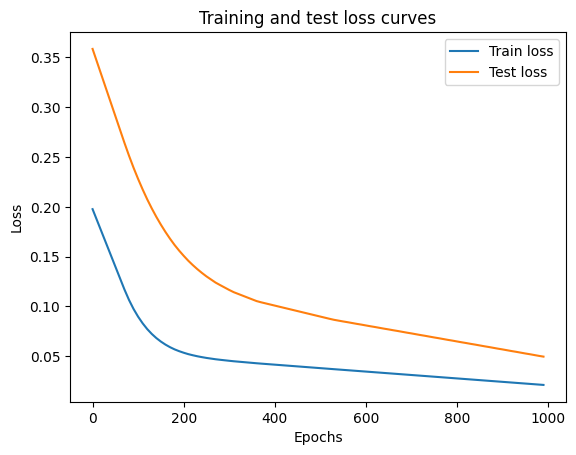

In [18]:
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [20]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bais}")

The model learned the following values for weights and bias:
OrderedDict({'weights': tensor([0.5959]), 'bias': tensor([0.3437])})

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## Making predictions with a trained PyTorch model (inference)

Once you've trained a model, you'll likely want to make predictions with it.

We've already seen a glimpse of this in the training and testing code above, the steps to do it outside of the training/testing loop are similar.

- There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

- Set the model in evaluation mode (model.eval()).
Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).
  
- All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

In [21]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([0.8204, 0.8323, 0.8443, 0.8562, 0.8681, 0.8800, 0.8919, 0.9038, 0.9158,
        0.9277])

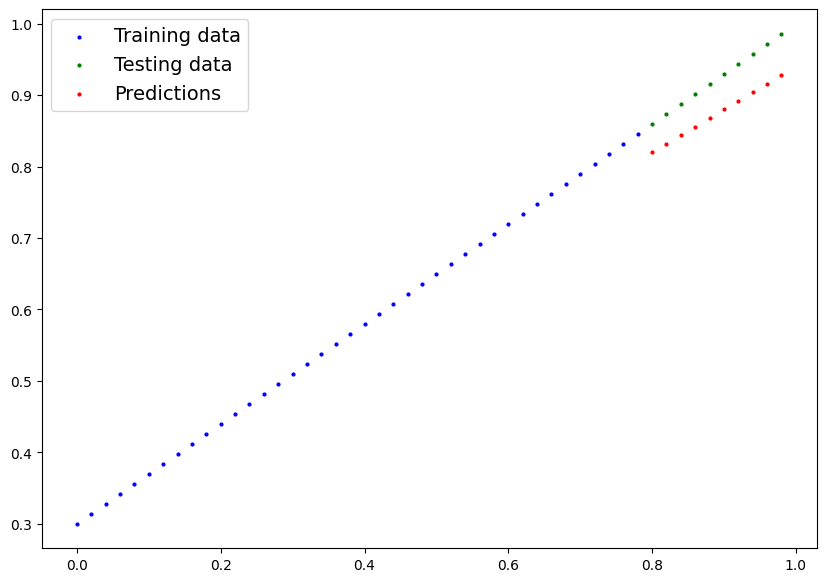

In [22]:
plot_predictions(predictions=y_preds)

### Saving and loading a PyTorch model

If you've trained a PyTorch model, chances are you'll want to save it and export it somewhere.

As in, you might train it on Google Colab or your local machine with a GPU but you'd like to now export it to some sort of application where others can use it.

In [ ]:
# SAVE THE MODEL

from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\01_pytorch_workflow_model_0.pth


In [30]:
# LOAD THE SAVED MODEL

# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)

# load_state_dict ----> Copy parameters and buffers from state_dict into this module and its descendants.
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>


Excellent! It looks like things matched up.

Now to test our loaded model, let's perform inference with it (make predictions) on the test data.

In [34]:
# put the model in to evaluation mode
loaded_model_0.eval()

# use the inference mode context manager to make perdictions
with torch.inference_mode():
    loadede_model_predictions =  loaded_model_0(X_test)
    print(loadede_model_predictions)


# check
y_preds == loadede_model_predictions


tensor([0.8204, 0.8323, 0.8443, 0.8562, 0.8681, 0.8800, 0.8919, 0.9038, 0.9158,
        0.9277])


tensor([True, True, True, True, True, True, True, True, True, True])

### Using the GPU 

In [35]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Set model to GPU if it's available, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

- Note: Many data science libraries such as pandas, matplotlib and NumPy aren't capable of using data that is stored on GPU. So you might run into some issues when trying to use a function from one of these libraries with tensor data not stored on the CPU. To fix this, you can call .cpu() on your target tensor to return a copy of your target tensor on the CPU.

In [ ]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())